In [35]:
#load in modules
import 
import rasterio
from rasterio.plot import show
from matplotlib import pyplot
from pathlib import Path
import os

In [21]:
#read in filepaths for data

filepath_post = Path("./data/Paradise/post")
filepath_pre = Path("./data/Paradise/pre")

#WorldView Post/Pre
fps_wv_post = list(filepath_post.glob("2*.tif"))
fps_wv_pre = list(filepath_pre.glob("2*.tif"))

#Sent2 Post/Pre
fp_sent2_post = filepath_post / "B08_post_clipped.tif"
fp_sent2_pre = filepath_pre / "B08_pre_clipped.tif"

In [24]:
dataset = rasterio.open(fps_wv_post[0])
print(dataset.name)
print(dataset.mode)
print(dataset.closed)
print(dataset.width)
print(dataset.height)

data\Paradise\post\2010133_post_clipped.tif
r
False
39682
46217


In [25]:
fps_wv_post[0]

WindowsPath('data/Paradise/post/2010133_post_clipped.tif')

In [27]:
dataset_pre = rasterio.open(fps_wv_pre[0])
print(dataset_pre.width)
print(dataset_pre.height)

39682
46217


In [38]:
dataset_pre.width * dataset_pre.height * 10

18339829940

In [28]:
dataset.bounds

BoundingBox(left=-121.68724060058594, bottom=39.653248506433826, right=-121.50915258071002, top=39.8606648164637)

In [29]:
dataset.transform

Affine(4.487879136029412e-06, 0.0, -121.68724060058594,
       0.0, -4.487879136029412e-06, 39.8606648164637)

In [30]:
dataset.crs

CRS.from_epsg(4326)

In [31]:
dataset.indexes

(1, 2, 3)

In [34]:
rgb = dataset.read()

KeyboardInterrupt: 

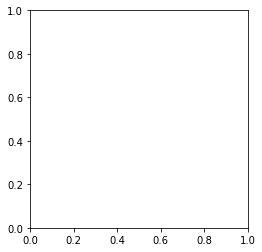

In [40]:
show(rgb, transform=dataset.transform)

In [ ]:
band1 = None